In [1]:
import random
import shutil
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from compressai.datasets import ImageFolder
from compressai.zoo import image_models
from compressai.optimizers import net_aux_optimizer
from compressai.losses import RateDistortionLoss

In [2]:
model='bmshj2018-factorized'
dataset='/home/server/datasets/example'
epochs=100
learning_rate=0.0001
num_workers=1
lmbda=0.01
batch_size=16
test_batch_size=64
aux_learning_rate=0.001
patch_size=(256, 256)
cuda=True
save=True
seed=0
clip_max_norm=1.0
# checkpoint=None
checkpoint = 'checkpoint_best_loss.pth.tar'

In [3]:
def configure_optimizers(net):
    """Separate parameters for the main optimizer and the auxiliary optimizer.
    Return two optimizers"""
    conf = {
        "net": {"type": "Adam", "lr": learning_rate},
        "aux": {"type": "Adam", "lr": aux_learning_rate},
    }
    optimizer = net_aux_optimizer(net, conf)
    return optimizer["net"], optimizer["aux"]

In [4]:
def train_one_epoch(
    model, criterion, train_dataloader, optimizer, aux_optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()
        aux_optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        aux_loss = model.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f} |'
                f'\tBpp loss: {out_criterion["bpp_loss"].item():.2f} |'
                f"\tAux loss: {aux_loss.item():.2f}"
            )

In [5]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    bpp_loss = AverageMeter()
    mse_loss = AverageMeter()
    aux_loss = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            out_criterion = criterion(out_net, d)

            aux_loss.update(model.aux_loss())
            bpp_loss.update(out_criterion["bpp_loss"])
            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        f"\tBpp loss: {bpp_loss.avg:.2f} |"
        f"\tAux loss: {aux_loss.avg:.2f}\n"
    )

    return loss.avg

In [6]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")

In [8]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)
test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="test", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda"),
)

net = image_models[model](quality=3)
net = net.to(device)
optimizer, aux_optimizer = configure_optimizers(net)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = RateDistortionLoss(lmbda=lmbda)
last_epoch = 0

if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    aux_optimizer.load_state_dict(checkpoint["aux_optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

Loading checkpoint_best_loss.pth.tar


In [9]:
for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        aux_optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "aux_optimizer": aux_optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
net.update()

True

In [26]:
import PIL.Image as Image
import torchvision
from diffusers.utils import pt_to_pil

In [11]:
t2 = next(iter(train_dataloader))

In [12]:
t2.shape

torch.Size([16, 3, 256, 256])

256
256


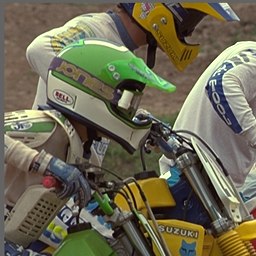

In [56]:
img = Image.open('kodim05.png')
img = img.crop((0,0,256,256))
def pil_to_pt(img):
    t = transforms.functional.pil_to_tensor(img)
    t = t.to(torch.float)
    t = t/255
    t = t.unsqueeze(0)
    return t
t = pil_to_pt(img)
print(img.width)
print(img.height)
img

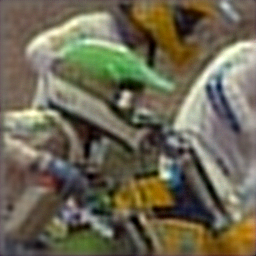

In [64]:
z = net.g_a(t.to("cuda"))
y = net.g_s(z)
x = y.detach()
pt_to_pil(2*x-1)[0]